In [44]:
#importing packages
# Data Management/Investigation
import pandas as pd
from pandas.api.types import CategoricalDtype # Ordering categories
import numpy as np
import missingno as miss

# Plotting libraries
from plotnine import *
import matplotlib.pyplot as plt

# For pre-processing data 
from sklearn import preprocessing as pp 
from sklearn.compose import ColumnTransformer 

# For splits and CV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold # Cross validation 
from sklearn.model_selection import cross_validate # Cross validation 
from sklearn.model_selection import GridSearchCV # Cross validation + param. tuning.

# Machine learning methods 
from sklearn.naive_bayes import GaussianNB as NB
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.tree import DecisionTreeClassifier as DT
from sklearn.tree import DecisionTreeRegressor as DT_reg
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn import tree # For plotting the decision tree rules

# For evaluating our model's performance
import sklearn.metrics as m

# Pipeline to combine modeling elements
from sklearn.pipeline import Pipeline

# For model interpretation
from sklearn.inspection import (
    permutation_importance,
    partial_dependence, 
    PartialDependenceDisplay, 
    plot_partial_dependence
)

# Misc
import warnings
warnings.filterwarnings("ignore")

In [45]:
#reading in cms enrollment data
enroll_dta=pd.read_csv("/Users/carolineadams/Documents/Georgetown/F21/DS1/FinalProject/PPOL564_Final_Project/Data/cms_enrollment_dta.csv")
enroll_dta=enroll_dta[enroll_dta['final_report'] == "Y"]
enroll_dta=enroll_dta[['state_name', "report_date", "state_expanded_medicaid", "total_medicaid_enrollment"]]
enroll_dta['state_expanded_medicaid'] = enroll_dta['state_expanded_medicaid'].str.replace('N','0')
enroll_dta['state_expanded_medicaid'] = enroll_dta['state_expanded_medicaid'].str.replace('Y','1')
enroll_dta.rename(columns={"state_name":"State"}, inplace=True)  #renaming the columns
enroll_dta['state_expanded_medicaid'] = pd.to_numeric(enroll_dta['state_expanded_medicaid'], downcast="float")

enroll_dta_18_20=enroll_dta[(enroll_dta.report_date=="2018-02-01") | (enroll_dta.report_date=="2018-03-01") | (enroll_dta.report_date=="2018-04-01") | (enroll_dta.report_date=="2019-02-01") | (enroll_dta.report_date=="2019-03-01") | (enroll_dta.report_date=="2019-04-01") | (enroll_dta.report_date=="2020-02-01") | (enroll_dta.report_date=="2020-03-01") | (enroll_dta.report_date=="2020-04-01")]
enroll_dta_18_20=enroll_dta_18_20.reset_index()
enroll_dta_18_20=enroll_dta_18_20.drop(columns=['index'])

In [46]:
partisan_lean=pd.read_csv("/Users/carolineadams/Documents/Georgetown/F21/DS1/FinalProject/PPOL564_Final_Project/Data/partisan_lean.csv")
partisan_lean=partisan_lean.drop(columns=['Unnamed: 0'])

In [47]:
#loading in and modifying eligibility data
elig_dta=pd.read_csv("/Users/carolineadams/Documents/Georgetown/F21/DS1/FinalProject/PPOL564_Final_Project/Data/rted_dta_kff.csv")
elig_dta=elig_dta[['Location', "State is Able to Make Real-Time Medicaid Eligibility Determinations (<24 Hours)"]]
elig_dta=elig_dta.drop([0])
#elig_dta['State is Able to Make Real-Time Medicaid Eligibility Determinations (<24 Hours)'] = elig_dta['State is Able to Make Real-Time Medicaid Eligibility Determinations (<24 Hours)'].str.replace('Not reported',"NaN")
elig_dta=elig_dta.replace({"Not reported": np.nan})
elig_dta['State is Able to Make Real-Time Medicaid Eligibility Determinations (<24 Hours)'] = elig_dta['State is Able to Make Real-Time Medicaid Eligibility Determinations (<24 Hours)'].str.replace('Yes','1')
elig_dta['State is Able to Make Real-Time Medicaid Eligibility Determinations (<24 Hours)'] = elig_dta['State is Able to Make Real-Time Medicaid Eligibility Determinations (<24 Hours)'].str.replace('No','0')

elig_dta['State is Able to Make Real-Time Medicaid Eligibility Determinations (<24 Hours)'] = pd.to_numeric(elig_dta['State is Able to Make Real-Time Medicaid Eligibility Determinations (<24 Hours)'], downcast="float")
elig_dta.rename(columns={"Location":"State", "State is Able to Make Real-Time Medicaid Eligibility Determinations (<24 Hours)":"Real-Time Eligibility Determination Ability (<24 Hours)"}, inplace=True)  #renaming the columns


In [48]:
#reading in MCO data
mco_dta=pd.read_csv("/Users/carolineadams/Documents/Georgetown/F21/DS1/FinalProject/PPOL564_Final_Project/Data/mco_dta_kff.csv")
mco_dta.loc[mco_dta['Total Medicaid MCOs'] > 0, 'Total Medicaid MCOs'] = 1
mco_dta.loc[mco_dta['Total Medicaid MCOs'] != 1, 'Total Medicaid MCOs'] = 0
mco_dta=mco_dta.drop([0])
mco_dta.rename(columns={"Location":"State", "Total Medicaid MCOs":"Managed Care"}, inplace=True)  #renaming the columns
mco_dta

,State,Managed Care
1,Alabama,0.0
2,Alaska,0.0
3,Arizona,1.0
4,Arkansas,0.0
5,California,1.0
6,Colorado,1.0
7,Connecticut,0.0
8,Delaware,1.0
9,District of Columbia,1.0
10,Florida,1.0


In [49]:
#loading in eligibility determination time data
elig_det_dta_18=pd.read_csv("/Users/carolineadams/Documents/Georgetown/F21/DS1/FinalProject/PPOL564_Final_Project/Data/state_app_time_data2018.csv")

elig_det_dta_18.rename(columns={"Percent of Determinations Processed\n< 24 hours":"Percent of Determinations Processed within 24 Hours", "Percent of Determinations Processed\n1 - 7 Days":"Percent of Determinations Processed Between 1 and 7 Days", "Percent of Determinations Processed\n8 - 30 Days":"Percent of Determinations Processed Between 8 and 30 Days", "Percent of Determinations Processed\n31- 45 Days":"Percent of Determinations Processed Between 31 and 45 Days", "Percent of Determinations Processed\n45+ Days":"Percent of Determinations Processed After 45 Days"}, inplace=True)  #renaming the columns
#elig_det_dta_18['Year']=2018

elig_det_dta_18['Month'] = elig_det_dta_18['Month'].str.replace('February','2018-02-01')
elig_det_dta_18['Month'] = elig_det_dta_18['Month'].str.replace('March','2018-03-01')
elig_det_dta_18['Month'] = elig_det_dta_18['Month'].str.replace('April','2018-04-01')
elig_det_dta_18.rename(columns={"Month":"Date"}, inplace=True)  #renaming the columns

elig_det_dta_19=pd.read_csv("/Users/carolineadams/Documents/Georgetown/F21/DS1/FinalProject/PPOL564_Final_Project/Data/state_app_time_dta2019.csv")
elig_det_dta_19.rename(columns={"Percent of Determinations Processed\n< 24 hours":"Percent of Determinations Processed within 24 Hours", "Percent of Determinations Processed\n1 - 7 Days":"Percent of Determinations Processed Between 1 and 7 Days", "Percent of Determinations Processed\n8 - 30 Days":"Percent of Determinations Processed Between 8 and 30 Days", "Percent of Determinations Processed\n31- 45 Days":"Percent of Determinations Processed Between 31 and 45 Days", "Percent of Determinations Processed\n45+ Days":"Percent of Determinations Processed After 45 Days"}, inplace=True)  #renaming the columns
elig_det_dta_19['Percent of Determinations Processed within 24 Hours']=elig_det_dta_19['Percent of Determinations Processed within 24 Hours']*100
elig_det_dta_19['Percent of Determinations Processed Between 1 and 7 Days']=elig_det_dta_19['Percent of Determinations Processed Between 1 and 7 Days']*100
elig_det_dta_19['Percent of Determinations Processed Between 8 and 30 Days']=elig_det_dta_19['Percent of Determinations Processed Between 8 and 30 Days']*100
elig_det_dta_19['Percent of Determinations Processed Between 31 and 45 Days']=elig_det_dta_19['Percent of Determinations Processed Between 31 and 45 Days']*100
elig_det_dta_19['Percent of Determinations Processed After 45 Days']=elig_det_dta_19['Percent of Determinations Processed After 45 Days']*100

elig_det_dta_19['Month'] = elig_det_dta_19['Month'].str.replace('February','2019-02-01')
elig_det_dta_19['Month'] = elig_det_dta_19['Month'].str.replace('March','2019-03-01')
elig_det_dta_19['Month'] = elig_det_dta_19['Month'].str.replace('April','2019-04-01')
elig_det_dta_19.rename(columns={"Month":"Date"}, inplace=True)  #renaming the columns
elig_det_dta_19

elig_det_dta_20=pd.read_csv("/Users/carolineadams/Documents/Georgetown/F21/DS1/FinalProject/PPOL564_Final_Project/Data/state_app_time_data2020.csv")

elig_det_dta_20.rename(columns={"Percent of Determinations Processed\n< 24 hours":"Percent of Determinations Processed within 24 Hours", "Percent of Determinations Processed\n1 - 7 Days":"Percent of Determinations Processed Between 1 and 7 Days", "Percent of Determinations Processed\n8 - 30 Days":"Percent of Determinations Processed Between 8 and 30 Days", "Percent of Determinations Processed\n31- 45 Days":"Percent of Determinations Processed Between 31 and 45 Days", "Percent of Determinations Processed\n45+ Days":"Percent of Determinations Processed After 45 Days"}, inplace=True)  #renaming the columns
elig_det_dta_20['Month'] = elig_det_dta_20['Month'].str.replace('February','2020-02-01')
elig_det_dta_20['Month'] = elig_det_dta_20['Month'].str.replace('March','2020-03-01')
elig_det_dta_20['Month'] = elig_det_dta_20['Month'].str.replace('April','2020-04-01')
elig_det_dta_20.rename(columns={"Month":"Date"}, inplace=True)  #renaming the columns
elig_det_dta_20
all_elig_det_dta=elig_det_dta_18.append(elig_det_dta_19)

all_elig_det_dta=all_elig_det_dta.append(elig_det_dta_20)
all_elig_det_dta

,State,Date,Percent of Determinations Processed within 24 Hours,Percent of Determinations Processed Between 1 and 7 Days,Percent of Determinations Processed Between 8 and 30 Days,Percent of Determinations Processed Between 31 and 45 Days,Percent of Determinations Processed After 45 Days
0,Alabama,2018-02-01,74.4,15.7,8.1,1.0,0.8
1,Alabama,2018-03-01,74.8,15.8,8.0,1.0,0.5
2,Alabama,2018-04-01,75.0,15.3,8.2,0.8,0.7
3,Alaska,2018-02-01,8.7,28.5,24.0,6.3,32.5
4,Alaska,2018-03-01,12.1,24.8,25.5,5.7,32.0
...,...,...,...,...,...,...,...
151,Wyoming,2020-03-01,48.9,19.1,22.4,4.5,5.0
152,Wyoming,2020-04-01,59.3,24.6,11.0,2.6,2.5
153,National Total,2020-02-01,44.7,12.4,20.6,6.5,15.8
154,National Total,2020-03-01,47.0,13.8,19.7,5.9,13.6


In [50]:
#merging all data together

all_dta_18_20=enroll_dta_18_20.merge(partisan_lean, how="outer", on="State")
all_dta_18_20=all_dta_18_20.merge(elig_dta, how="outer", on="State")
all_dta_18_20=all_dta_18_20.merge(mco_dta, how="outer", on="State")
all_dta_18_20.rename(columns={"report_date":"Date"}, inplace=True)  #renaming the columns
all_dta_18_20=all_dta_18_20.merge(mco_dta, how="outer", on="State")
all_dta_18_20=all_dta_18_20.merge(all_elig_det_dta, how="outer", on=["State", "Date"])
all_dta_18_20['most_det_complete_oneweek']=np.where(all_dta_18_20['Percent of Determinations Processed within 24 Hours']+all_dta_18_20['Percent of Determinations Processed Between 1 and 7 Days']>50, 1, 0)
#conditions = [(all_dta_18_20['Percent of Determinations Processed within 24 Hours']+all_dta_18_20['Percent of Determinations Processed Between 1 and 7 Days']>50)]
#values = [1,0]
#all_dta_18_20['most_det_complete_oneweek']
               
all_dta_18_20=all_dta_18_20.drop(columns=['Percent of Determinations Processed within 24 Hours', "Percent of Determinations Processed Between 1 and 7 Days", "Percent of Determinations Processed Between 8 and 30 Days", "Percent of Determinations Processed Between 31 and 45 Days", "Percent of Determinations Processed After 45 Days", "Managed Care_y"])
all_dta_18_20.rename(columns={"Managed Care_x":"managed_care"}, inplace=True)  #renaming the columns

all_dta_18_20

,State,Date,state_expanded_medicaid,total_medicaid_enrollment,Partisan Lean,Real-Time Eligibility Determination Ability (<24 Hours),managed_care,most_det_complete_oneweek
0,Alabama,2018-02-01,0.0,722951.0,-29.6,1.0,0.0,1
1,Alabama,2018-03-01,0.0,725440.0,-29.6,1.0,0.0,1
2,Alabama,2018-04-01,0.0,726911.0,-29.6,1.0,0.0,1
3,Alabama,2019-02-01,0.0,739062.0,-29.6,1.0,0.0,1
4,Alabama,2019-03-01,0.0,738636.0,-29.6,1.0,0.0,1
...,...,...,...,...,...,...,...,...
462,National Total,2019-02-01,NaN,NaN,NaN,NaN,NaN,0
463,National Total,2019-03-01,NaN,NaN,NaN,NaN,NaN,1
464,National Total,2020-02-01,NaN,NaN,NaN,NaN,NaN,1
465,National Total,2020-03-01,NaN,NaN,NaN,NaN,NaN,1


In [51]:
#examining data types for all variables
all_dta_18_20.dtypes

State                                                       object
Date                                                        object
state_expanded_medicaid                                    float32
total_medicaid_enrollment                                  float64
Partisan Lean                                              float64
Real-Time Eligibility Determination Ability (<24 Hours)    float32
managed_care                                               float64
most_det_complete_oneweek                                    int64
dtype: object

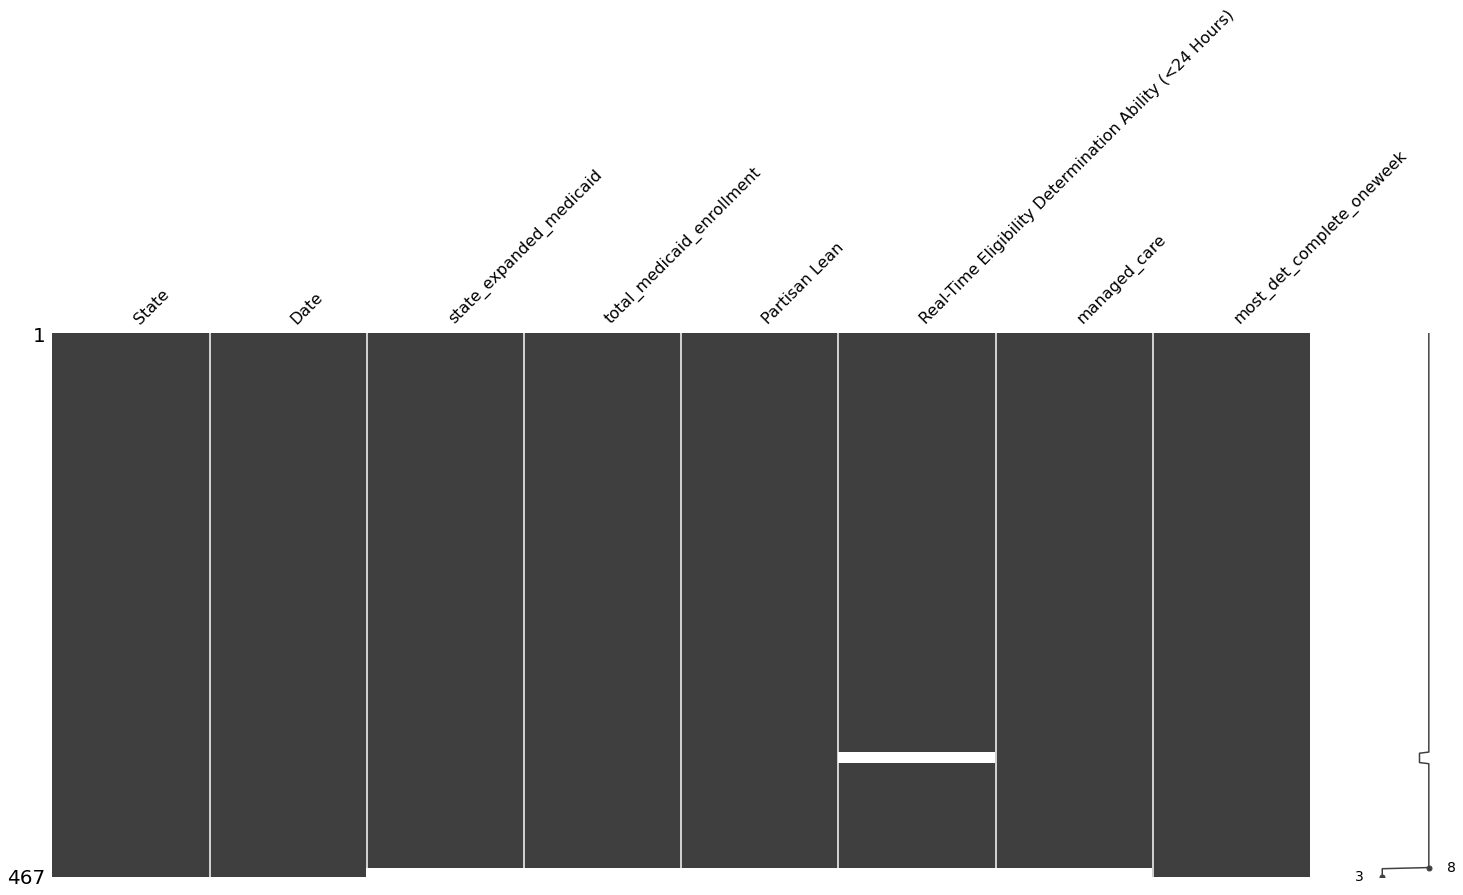

In [52]:
#assess for missingness in dataset
fig=miss.matrix(all_dta_18_20)
fig_copy = fig.get_figure()
fig_copy.savefig('MissingData.png')

In [10]:
#drop NA values in dataset
all_dta_18_20.dropna(inplace=True)

In [11]:
#finding sample size after dropping NA values
all_dta_18_20.shape

(450, 8)

In [12]:
#convert all numerical variables to integers
all_dta_18_20[['state_expanded_medicaid', "total_medicaid_enrollment","Partisan Lean", "Real-Time Eligibility Determination Ability (<24 Hours)", "managed_care"]]=all_dta_18_20[['state_expanded_medicaid', "total_medicaid_enrollment","Partisan Lean", "Real-Time Eligibility Determination Ability (<24 Hours)", "managed_care"]].astype(int)

In [13]:
#set y equal to outcome variable
train_y = all_dta_18_20[['most_det_complete_oneweek']]
#set x equal to other variables; drop Status variable
train_x = all_dta_18_20.drop(columns=['most_det_complete_oneweek'])
#split data into training x and y data
#train_x, test_x, train_y, test_y = train_test_split(x,y,test_size = 0,random_state=202011)

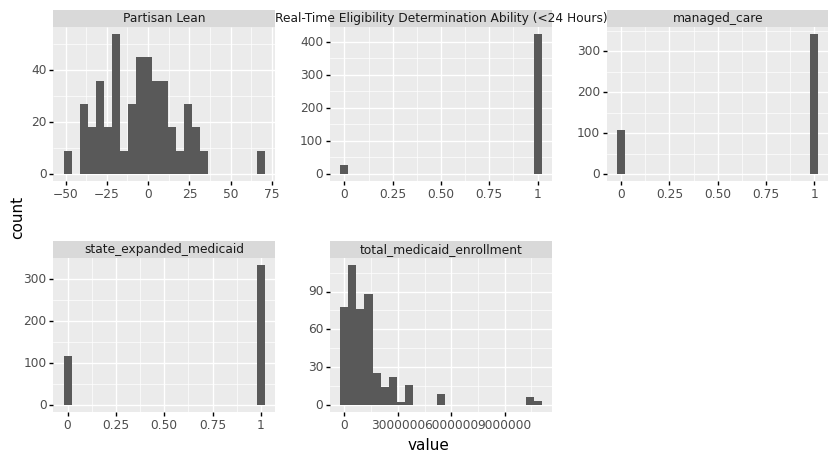

<ggplot: (8774531834856)>

In [14]:
#plotting the continuous variables
d = train_x.select_dtypes(include="int").melt()
(
    ggplot(d,aes(x="value")) +
    geom_histogram(bins=25) +
    facet_wrap("variable",scales='free') +
    theme(figure_size=(10,5),
          subplots_adjust={'wspace':0.25, "hspace": 0.5})
)

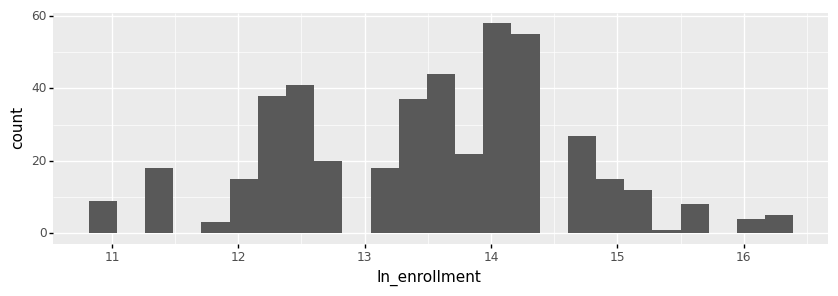

<ggplot: (8774530940474)>

In [15]:
#create a copy of train_x
d = train_x.copy()
#examine what would happen if the assets variable were logged
d['ln_enrollment'] =  np.log(d['total_medicaid_enrollment'])
(
    ggplot(d,aes(x="ln_enrollment")) +
    geom_histogram(bins=25) +
    theme(figure_size=(10,3),
          subplots_adjust={'wspace':0.25})
)

# preprocessing

In [16]:
#log total enrollment
all_dta_18_20['ln_enrollment'] =  np.log(all_dta_18_20['total_medicaid_enrollment'])
all_dta_18_20=all_dta_18_20.drop(columns=["total_medicaid_enrollment"])

In [17]:
#create dummy variables for all states
state_dummies=pd.get_dummies(all_dta_18_20.State)
state_dummies = state_dummies.drop(['Alabama'],axis=1) # Baseline state
state_dummies.head()

,Alaska,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,District of Columbia,Florida,Georgia,...,South Dakota,Tennessee,Texas,Utah,Vermont,Virginia,Washington,West Virginia,Wisconsin,Wyoming
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [18]:
all_dta_18_20=pd.concat([all_dta_18_20.drop(columns=['State']),state_dummies],axis=1)
all_dta_18_20

,Date,state_expanded_medicaid,Partisan Lean,Real-Time Eligibility Determination Ability (<24 Hours),managed_care,most_det_complete_oneweek,ln_enrollment,Alaska,Arizona,Arkansas,...,South Dakota,Tennessee,Texas,Utah,Vermont,Virginia,Washington,West Virginia,Wisconsin,Wyoming
0,2018-02-01,0,-29,1,0,1,13.491097,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2018-03-01,0,-29,1,0,1,13.494534,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2018-04-01,0,-29,1,0,1,13.496559,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2019-02-01,0,-29,1,0,1,13.513137,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2019-03-01,0,-29,1,0,1,13.512561,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
454,2019-03-01,0,-49,1,0,0,10.881099,0,0,0,...,0,0,0,0,0,0,0,0,0,1
455,2019-04-01,0,-49,1,0,0,10.884704,0,0,0,...,0,0,0,0,0,0,0,0,0,1
456,2020-02-01,0,-49,1,0,1,10.851781,0,0,0,...,0,0,0,0,0,0,0,0,0,1
457,2020-03-01,0,-49,1,0,1,10.853174,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [19]:
#create dummy variables for months/years
date_dummies=pd.get_dummies(all_dta_18_20.Date)
date_dummies
date_dummies = date_dummies.drop(columns=['2018-02-01']) # Baseline state
date_dummies.head()

,2018-03-01,2018-04-01,2019-02-01,2019-03-01,2019-04-01,2020-02-01,2020-03-01,2020-04-01
0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0
4,0,0,0,1,0,0,0,0


In [20]:
all_dta_18_20=pd.concat([all_dta_18_20.drop(columns=['Date']),date_dummies],axis=1)
all_dta_18_20

,state_expanded_medicaid,Partisan Lean,Real-Time Eligibility Determination Ability (<24 Hours),managed_care,most_det_complete_oneweek,ln_enrollment,Alaska,Arizona,Arkansas,California,...,Wisconsin,Wyoming,2018-03-01,2018-04-01,2019-02-01,2019-03-01,2019-04-01,2020-02-01,2020-03-01,2020-04-01
0,0,-29,1,0,1,13.491097,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,-29,1,0,1,13.494534,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,0,-29,1,0,1,13.496559,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,0,-29,1,0,1,13.513137,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,0,-29,1,0,1,13.512561,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
454,0,-49,1,0,0,10.881099,0,0,0,0,...,0,1,0,0,0,1,0,0,0,0
455,0,-49,1,0,0,10.884704,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
456,0,-49,1,0,1,10.851781,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
457,0,-49,1,0,1,10.853174,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0


In [21]:
train_y = all_dta_18_20[['most_det_complete_oneweek']]
train_x = all_dta_18_20.drop(columns=['most_det_complete_oneweek'])


# cross validation

In [22]:
# Set the folds index to ensure comparable samples
fold_generator = KFold(n_splits=10, shuffle=True,random_state=1234)

In [23]:
#initialize pipeline and scale values in pipeline
pipe = Pipeline(steps=[('pre_process', pp.MinMaxScaler()),('model',None)])

In [24]:
#select models to run and adding appropriate tuning parameters for each
search_space = [
    
    # NaiveBayes
    {'model': [NB()]},
    
    # KNN with K tuning param
    {'model' : [KNN()],
     'model__n_neighbors':[5,10,25,50]},
    
    # Decision Tree with the Max Depth Param
    {'model': [DT()],
     'model__max_depth':[2,3,4]},
    
    # Random forest with the N Estimators tuning param
    {'model' : [RF()],
    'model__max_depth':[2,3,4],
    'model__n_estimators':[500,1000,1500]}
    
]

In [25]:
#put together pipeline, models, number of folds, scoring metrics together in GridSearch
search = GridSearchCV(pipe, search_space, 
                      cv = fold_generator,
                      scoring='roc_auc',
                      n_jobs=4, error_score='raise')


In [26]:
#fitting models to training data; running the models
search.fit(train_x,train_y.most_det_complete_oneweek)

GridSearchCV(cv=KFold(n_splits=10, random_state=1234, shuffle=True),
             error_score='raise',
             estimator=Pipeline(steps=[('pre_process', MinMaxScaler()),
                                       ('model', None)]),
             n_jobs=4,
             param_grid=[{'model': [GaussianNB()]},
                         {'model': [KNeighborsClassifier()],
                          'model__n_neighbors': [5, 10, 25, 50]},
                         {'model': [DecisionTreeClassifier()],
                          'model__max_depth': [2, 3, 4]},
                         {'model': [RandomForestClassifier()],
                          'model__max_depth': [2, 3, 4],
                          'model__n_estimators': [500, 1000, 1500]}],
             scoring='roc_auc')

In [27]:
#identifying the best neg MSE score obtained by the four models
search.best_score_

0.9530856194379587

In [28]:
search.best_params_

{'model': KNeighborsClassifier(), 'model__n_neighbors': 5}

In [29]:
rf_mod = search.best_estimator_

In [30]:
# Predict() method will use the best model out of the scan
pred_y = search.predict(train_x)
m.mean_squared_error(train_y,pred_y)

0.06222222222222222

In [31]:
m.r2_score(train_y,pred_y)

0.7456395348837208

In [41]:
m.roc_auc_score(train_y,rf_mod.predict_proba(train_x)[:,1])

0.9848090277777778

In [32]:
m.accuracy_score(train_y,rf_mod.predict(train_x))

0.9377777777777778

In [33]:
vi = permutation_importance(rf_mod,train_x,train_y,n_repeats=25)

In [34]:
# Organize as a data frame 
vi_dat = pd.DataFrame(dict(variable=train_x.columns,
                           vi = vi['importances_mean'],
                           std = vi['importances_std']))

# Generate intervals
vi_dat['low'] = vi_dat['vi'] - 2*vi_dat['std']
vi_dat['high'] = vi_dat['vi'] + 2*vi_dat['std']

# But in order from most to least important
vi_dat = vi_dat.sort_values(by="vi",ascending=False).reset_index(drop=True)


vi_dat

,variable,vi,std,low,high
0,ln_enrollment,0.064356,0.012484,0.039388,0.089323
1,managed_care,0.051822,0.008042,0.035738,0.067907
2,Partisan Lean,0.034667,0.009838,0.014990,0.054343
3,Virginia,0.020533,0.001138,0.018257,0.022810
4,North Dakota,0.020178,0.001394,0.017389,0.022966
...,...,...,...,...,...
57,2019-04-01,-0.000978,0.001787,-0.004551,0.002596
58,Montana,-0.002400,0.000871,-0.004142,-0.000658
59,Vermont,-0.002578,0.001206,-0.004989,-0.000166
60,Illinois,-0.004000,0.000889,-0.005778,-0.002222


In [53]:
# Plot
p=(
    ggplot(vi_dat[0:3],
          aes(x="variable",y="vi")) +
    geom_col(alpha=.5) +
    geom_point() +
    geom_errorbar(aes(ymin="low",ymax="high"),width=.2) +
    theme_bw() +
    scale_x_discrete(limits=vi_dat.variable[0:3].tolist()) +
    coord_flip() +
    ggtitle("Figure 6. Top 3 Variables with Most Importance in Best-Fitting Model") +
    labs(y="Reduction in AUC ROC",x="")
)
ggsave(plot = p, filename = "Reduction_in_AUCROC.png", dpi=300)
